# Pytorch Homework 3: 利用 stanford dog (mini) dataset 來訓練一個分類器。

## 作業說明

這次的作業總共有 4 個部份，必須完成助教提供的 ipynb 檔，在檔案中某些區塊會有 ??? 處需要完成。

0. 安裝需要使用的 package: pip install -r requirements.txt

1. 實作 Dataloader
    * 1.1. 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset。 ** (10%) **
    * 1.2. 將每一個類別以 8 : 2 的比例分割成 Training data 和 Testing data 傳至 dataloader  ** (15%) **

2. 建構 CNN model。
    * 2.1. 利用 Pytorch 內建的 CNN model 來進行訓練。 ** (10%) **
    * 2.2. 自行設計一個新的 CNN model 來進行訓練。 ** (20%) ** (至少達到 70% 以上的 Testing accuracy，否則只有一半的分數)
    * 2.3. 利用 torchsummary 來印出上面兩個模型的架構資訊。 ** (5%) **

3. 實作模型訓練和測試模型效能。 ** (30%) **
4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖並儲存下來。 ** (10%) **
    
## 作業繳交

* Deadline : 11/16 中午12:00        
    * **遲交一天打 7 折**
    * **遲交兩天打 5 折**
    * **遲交三天以上不給予分數**
    
* 繳交方式 : 請將完成的 ipynb 檔 (分成兩個版本: 內建 model 版和自己設計的版本) 以及 Loss、Training / testing accuracy 的圖片，壓縮後上傳至 moodle。
    * 建議先完成一個版本，然後將檔案複製後再完成另一個版本
    
* 壓縮檔內包含 :
    * (你的學號)\_(姓名)\_HW3_2_1.ipynb  (E.g.F77777777_王小明_HW3_2_1.ipynb) 
    * (你的學號)\_(姓名)\_HW3_2_2.ipynb  (E.g.F77777777_王小明_HW3_2_2.ipynb) 
    * 兩個版本的 Loss.png、Acc.png (Loss_2_1.png、Loss_2_2.png、Acc_2_1.png、Acc_2_2.png)
    * **格式不對的話會扣 10 分！！！**
    
* 有任何問題歡迎寄信至我的信箱
    * 曹維廷 a0903511820@gmail.com

In [14]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Part 1：Dataloader 實作

In [17]:
# 1.1. 填入 ??? 的部份

class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames # 資料集的所有檔名
        self.labels = labels # 影像的標籤
        self.transform = transform # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames) # return DataSet 長度
 
    def __getitem__(self, idx):
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) #??? # Transform image
        label = np.array(self.labels[idx])
                
        return image, label # return 模型訓練所需的資訊


In [18]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])
def split_Train_Val_Data(data_dir):
  dataset = ImageFolder(data_dir)

  # 建立 20 類的 list
  character = [[] for i in range(len(dataset.classes))]
  # print(character)

  # 將每一類的檔名依序存入相對應的 list
  for x, y in dataset.samples:
      character[y].append(x)#append each img X into diff label Y
    
  train_inputs, test_inputs = [], []
  train_labels, test_labels = [], []
  # print(len(character[3]))
  for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
      
      np.random.seed(42)
      np.random.shuffle(data)
      # -------------------------------------------
      # 將每一類都以 8:2 的比例分成訓練資料和測試資料
      # -------------------------------------------
      # print(int(len(data)/10)*8 ,int(len(data)/10)*8+1 )
      # print( type(character[i][data]))
      # print(character[i][])
      num_sample_train = int(len(data)*0.8)  #character[i][:int(len(data)/10)*8]
      num_sample_test = num_sample_train+1 #character[i][int(len(data)/10)*8+1:]
      # print(data)
      for x in data[:num_sample_train] :# 前 80% 資料存進 training list
          train_inputs.append(x)
          train_labels.append(i) 

          
      for x in data[num_sample_test:] : # 後 20% 資料存進 testing list
          test_inputs.append(x)
          test_labels.append(i)

      train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                    batch_size = batch_size, shuffle = True)
      test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
                                    batch_size = batch_size, shuffle = False)
  
  return train_dataloader, test_dataloader

### Part 2: 建立 CNN Model

In [19]:
# 2.2. 自行設計一個新的 CNN model

class BuildModel(nn.Module):
    
    def __init__(self):
        super(BuildModel, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),,
            nn.MaxPool2d(kernel_size=2,stride=2),
            #2
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #3
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #4
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #5
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #6
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #7
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #8
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #9
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.AvgPool2d(kernel_size=1,stride=1),
            )
        self.classifier = nn.Sequential(
            #10
            # nn.Linear(128*6*6,4096),
            nn.Linear(128*14*14,4096),
            nn.ReLU(True),
            nn.Dropout(),
            #11
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            #12
            nn.Linear(4096,20),
            )
               
    def forward(self, x):
        out = self.features(x)
        out = out.view(-1,128*14*14)
        out = self.classifier(out)
        return out

### Setting

依據需求調整參數

In [20]:
batch_size = 32
lr = 1e-3
epochs = 300

data_dir = '/content/drive/My Drive/ColabNotebooks/AI_HW3/stanford_dog'

In [21]:
# 2.3. 

train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

C = BuildModel().to(device) # 使用內建的 model 或是自行設計的 model
optimizer_C = optim.SGD(C.parameters(), lr = lr) # 選擇你想用的 optimizer
summary(C, (3, 224, 224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

# Loss function
criterion = nn.CrossEntropyLoss() # 選擇想用的 loss function

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

In [22]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

### 3. 實作模型訓練和測試模型效能

In [23]:
if __name__ == '__main__':    
    
    for epoch in range(epochs):
    
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
                        
            optimizer_C.zero_grad() # 清空梯度
            
            output = C(x) # 將訓練資料輸入至模型進行訓練
            loss = criterion(output, label) # 計算 loss
            
            loss.backward() # 將 loss 反向傳播
            optimizer_C.step() # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(output,1)
            total_train += label.size(0) #???
            correct_train += (predicted == label).sum()

            train_loss_C += loss.item()
            iter +=  1
                    
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad(): # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                
                test_output = C(x) # 將測試資料輸入至模型進行測試
                #??? # 計算測試資料的準確度
                
                _, predicted = torch.max(test_output.data,1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum()
        
        print('Testing acc: %.3f' % (correct_test / total_test))
                                     
        train_acc.append(100 * (correct_train / total_train)) # training accuracy
        test_acc.append(100 * (correct_test / total_test) ) # testing accuracy
        loss_epoch_C.append(train_loss_C / len(train_dataloader)) # loss  

epoch: 1 / 300
Training epoch: 1 / loss_C: 2.998 | acc: 0.061
Testing acc: 0.117
epoch: 2 / 300
Training epoch: 2 / loss_C: 2.962 | acc: 0.096
Testing acc: 0.145
epoch: 3 / 300
Training epoch: 3 / loss_C: 2.910 | acc: 0.114
Testing acc: 0.159
epoch: 4 / 300
Training epoch: 4 / loss_C: 2.851 | acc: 0.145
Testing acc: 0.171
epoch: 5 / 300
Training epoch: 5 / loss_C: 2.796 | acc: 0.143
Testing acc: 0.178
epoch: 6 / 300
Training epoch: 6 / loss_C: 2.737 | acc: 0.170
Testing acc: 0.208
epoch: 7 / 300
Training epoch: 7 / loss_C: 2.687 | acc: 0.175
Testing acc: 0.218
epoch: 8 / 300
Training epoch: 8 / loss_C: 2.652 | acc: 0.181
Testing acc: 0.235
epoch: 9 / 300
Training epoch: 9 / loss_C: 2.614 | acc: 0.209
Testing acc: 0.228
epoch: 10 / 300
Training epoch: 10 / loss_C: 2.585 | acc: 0.207
Testing acc: 0.242
epoch: 11 / 300
Training epoch: 11 / loss_C: 2.558 | acc: 0.215
Testing acc: 0.241
epoch: 12 / 300
Training epoch: 12 / loss_C: 2.527 | acc: 0.227
Testing acc: 0.263
epoch: 13 / 300
Traini

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

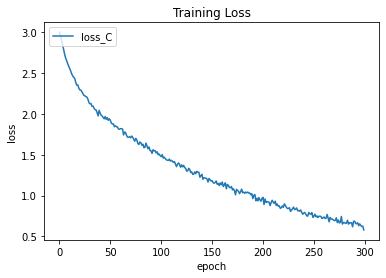

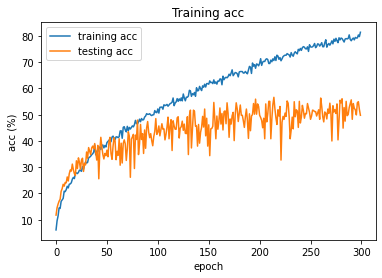

In [24]:
plt.figure()

plt.plot(loss_epoch_C) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.show()
 
plt.figure()

plt.plot(train_acc)#??? # plot your training accuracy
plt.plot(test_acc)#??? # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.show()